In [1]:
from model import create_model
from options.test_options import TestOptions
from PIL import Image
import torchvision.transforms as transforms
import torch.autograd
import torch.distributions
from util import task, util
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import skimage.transform
from rasterio.windows import Window

from data_science_tools.d3.digital_elevation_raster import DigitalElevationRaster
from data_science_tools.d3 import ColoredMesh
import rasterio.features
import geopandas as gpd
import shapely.geometry
from data_science_tools.d3.constants import NODATA_FLOAT
from data_science_tools.geometry import convert_geometry_crs
import multiprocessing
from data_science_tools.core.utils.smart_mp_pool import get_pool
from data_science_tools.core.utils.progress_bar import progress_bar
from data_science_tools.geometry import make_valid
import functools

In [2]:
def _get_one(dem, orig_attr_geom, threshold_height):
    
    recon_dem, roof_mask, new_attr_geom = get_masked_reconstructed_dem(orig_attr_geom, dem, threshold_height=threshold_height)
    
    cm = ColoredMesh.from_dem(recon_dem)
    
    return cm.total_area


def chainsaw_gan_area_meas(attr_geom_js, dem_file, mask_file, threshold_height, n_samples):
    
    inf = PluralisticInference()
    best, samples = inf.on_tiff(dem_file,
                                mask_file,
                                n_samples)
    
    orig_attr_geom = convert_geometry_crs(make_valid(shapely.geometry.shape(attr_geom_js)), 4326, best.metadata['crs'].to_epsg())
    
    with progress_bar(n_samples, units='sample', title='Computing areas on samples') as p:
        
        areas = []
        
        worker = functools.partial(_get_one, 
                                   orig_attr_geom=orig_attr_geom,
                                   threshold_height=threshold_height)
        
        with get_pool(multiprocessing.cpu_count()) as pool:
        
            for area in pool.imap(worker, samples):

                areas.append(area)
                p.increase()
    
    return areas

def get_masked_reconstructed_dem(orig_attr_geom, dem, threshold_height=2.0):
    
    # Threshold DEM
    thresholded = (dem.raster > threshold_height)
    _ = plt.imshow(thresholded.T)
    
    # Extract polygons
    s = gpd.GeoSeries([
        make_valid(shapely.geometry.shape(x[0])) 
        for x in rasterio.features.shapes(thresholded.astype(np.uint8), 
                                          connectivity=4, 
                                          mask=thresholded, 
                                          transform=dem.metadata['transform'])
    ])
    
    gdf = gpd.GeoDataFrame({'geometry': s, 'area': s.intersection(orig_attr_geom).area})
    
    # Find polygons that intersect with original attr geoms and
    # choose the new polygon with the largest intersection with the attr geom
    # before reconstruction
    new_attr_geom = gdf.sort_values(by='area', ascending=False).iloc[0]['geometry']
        
    # Mask everything else
    mask_roof = rasterio.features.rasterize([(shapely.geometry.mapping(new_attr_geom), False)],
                                            out_shape=dem.raster.shape,
                                            transform=dem.metadata['transform'],
                                            fill=True).astype(bool)
    
    rr = dem.raster.copy().flatten()
    rr[mask_roof.flatten()] = NODATA_FLOAT
    rr = rr.reshape(dem.raster.shape)

    new_meta = dict(dem.metadata)
    new_meta['history'] = "Applied CHAINSAW-GAN"

    return DigitalElevationRaster(rr, new_meta, dem.mercator_bounds), mask_roof, new_attr_geom


class PluralisticInference(object):
    
    def __init__(self):
        
        self._opt = opt = TestOptions().parse()
        self._opt.name = "cape_1"
        self._model = create_model(opt)
        self._transform = transforms.Compose([transforms.ToTensor()])
    
    @staticmethod
    def crop_geotiff(path, mask, crp=256):

        with rasterio.open(path) as src:

            # Compute window
            col_off = src.profile['width'] // 2 - crp // 2
            row_off = src.profile['height'] // 2 - crp // 2

            window = Window(col_off=col_off, 
                            row_off=row_off, 
                            width=crp, 
                            height=crp)

            kwargs = src.meta.copy()
            kwargs.update({
                'height': window.height,
                'width': window.width,
                'transform': rasterio.windows.transform(window, src.transform)})
            
            return np.squeeze(src.read(window=window)), kwargs, mask[col_off : col_off + crp,
                                                                     row_off : row_off + crp]
    
    def get_chip(self, input_dem):
                
        # Make sure this is a square
        assert input_dem.shape[0] == input_dem.shape[1], "Not a square!"
        assert input_dem.shape[0] == 256

        # Put to zero anything below 1.5 meters
        dem = np.clip(input_dem, 0.0, None)

        # Quantize on an absolute scale
        scale = np.linspace(0.0, 20.0, 256)

        q = np.searchsorted(scale, dem, side='left')

        assert q.min() >= 0
        assert q.max() <= 255

        # Duplicate on the RGB channels and return
        return np.array([q]*3).T.astype(np.uint8), scale, dem
    
    def _unscale(self, x, scale):
        
        return scale[np.array(Image.fromarray(x).convert("L"))].astype(np.float32)
    
    def on_tiff(self, tiff_file, mask_file, n_samples=50, plot=True):
                
        cropped_dem, cropped_dem_profile, resized_mask = self.crop_geotiff(tiff_file, mask=np.load(mask_file)['tree_mask'].T)
        
        orig_img, scale, dem = self.get_chip(cropped_dem)
        
        pil_im = Image.fromarray(resized_mask).convert('RGB')
        mask = torch.autograd.Variable(self._transform(pil_im)).unsqueeze(0)
        mask = (mask < 0.5).float()
        
        orig, mask, masked_image, reconstructed, samples = self.evaluate(orig_img, mask, n_samples=n_samples)
        
        if plot:
            self.plot(orig, mask, masked_image, reconstructed)
        
        return (DigitalElevationRaster(self._unscale(reconstructed, scale).T, cropped_dem_profile, None), 
                [DigitalElevationRaster(self._unscale(x, scale).T, cropped_dem_profile, None) for x in samples])
        
    
    def on_png(self, image_file, mask_file=None, n_samples=50):
        
        orig_img = Image.open(image_file).convert('RGB').resize(self._opt.loadSize)
        
        mask = self.read_mask(orig_img, mask_file)
        
        return self.evaluate(orig_img, mask, n_samples=n_samples)
    
    def read_mask(self, img, mask_file):
        
        if mask_file is not None:
            pil_im = Image.open(mask_file).resize(self._opt.loadSize)
            mask = torch.autograd.Variable(self._transform(pil_im)).unsqueeze(0)
            mask = (mask < 0.5).float()
        else:
            mask = (self._transform(img) == MASKED).float()
        
        return mask
    
    def plot(self, orig, mask, masked_image, reconstructed):
        
        fig, sub = plt.subplots(1, 4, figsize=(20, 5))


        _ = sub[0].imshow(orig)
        _ = sub[1].imshow(mask)
        _ = sub[2].imshow(masked_image)
        _ = sub[3].imshow(reconstructed)

        _ = [s.axis("off") for s in sub]
        
        return fig
    
    def evaluate(self, orig_img, mask, n_samples=100):
                
        img = self._transform(orig_img)
        
        img_truth = img * 2 - 1
        img_m = mask * img_truth
        img_c = (1 - mask) * img_truth
        
        max_score = 0.0

        results = {'score': [], 'image': []}

        with torch.no_grad():
            # encoder process
            distributions, f = self._model.net_E(img_m)
            q_distribution = torch.distributions.Normal(distributions[-1][0], distributions[-1][1])
            #q_distribution = torch.distributions.Normal( torch.zeros_like(distributions[-1][0]), torch.ones_like(distributions[-1][1]))
            
            for i in range(n_samples):
                z = q_distribution.sample()

                # decoder process
                scale_mask = task.scale_pyramid(mask, 4)
                img_g, atten = self._model.net_G(z, f_m=f[-1], f_e=f[2], mask=scale_mask[0].chunk(3, dim=1)[0])
                img_out = (1 - mask) * img_g[-1].detach().cpu() + mask * img_m

                # get score
                score = self._model.net_D(img_out).mean()

                if score > max_score:

                    img_g = img_g
                    atten = atten
                    img_out = img_out

                    max_score = score

                results['score'].append(score)
                results['image'].append(util.tensor2im(img_out.detach()))

        samples = [results['image'][i] for i in range(len(results['score']))]
        
        return util.tensor2im(img_truth), util.tensor2im(mask).astype(int), util.tensor2im(img_m), util.tensor2im(img_out.detach()), samples

In [3]:
import json

with open("/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/54.json") as fp:
    
    attr_geom_js = json.load(fp)['Target.BuildingGeometry']

initialize network with orthogonal
initialize network with orthogonal
initialize network with orthogonal
initialize network with orthogonal
model [Pluralistic] was created
Computing areas on samples :

[**********48.0%             ]  24 / 50 sample in 3.6 s (0:00:01 to go)

2020-08-27 16:50:53,322 Ring Self-intersection at or near point -11370884.57592673 3761339.8243448003


[**********60.0%**           ]  30 / 50 sample in 4.5 s (0:00:01 to go)

2020-08-27 16:50:54,263 Ring Self-intersection at or near point -11370882.271245824 3761341.0653268271


[*********100.0%*************]  50 / 50 sample in 5.7 s (0:00:00 to go)


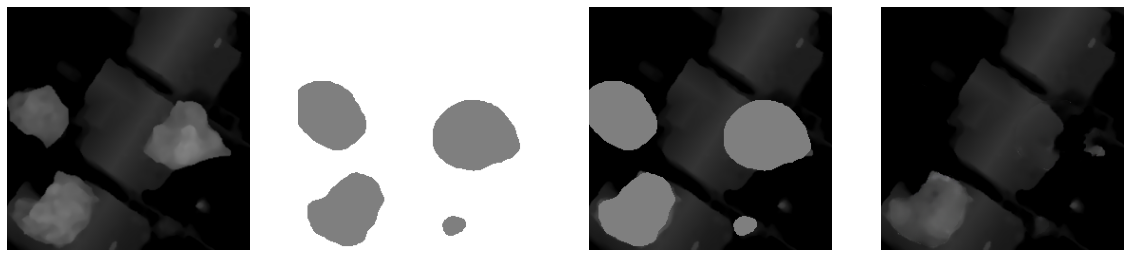

In [8]:
areas = chainsaw_gan_area_meas(
    attr_geom_js, 
    "/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/54_dem.tiff",
    "/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/54_tree_mask.npz",
    2.0,
    n_samples=50
)

In [9]:
np.std(areas)

9.388749390295079

In [10]:
np.mean(areas)

354.8827602862646

In [11]:
from data_science_tools.core.utils.geojson_spec import *

In [14]:
primary_roof = get_feature({'geometry': []}, {'type': 'house', 'primary': True, 'roof_condition_rating': 1, 'roof_geometry': 'hip', 'area': 1234})
secondary_roofs = [
    get_feature({'geometry': []}, {'type': 'garage', 'primary': False, 'roof_condition_rating': 1, 'roof_geometry': 'hip', 'area': 200}),
    get_feature({'geometry': []}, {'type': 'shed', 'primary': False, 'roof_condition_rating': 1, 'roof_geometry': 'hip', 'area': 50}),
                  ]
parcel = get_feature({'geometry': []}, {'type': 'parcel', 'secondary_structure_count': 2, 'yard_debris_pct': 5})

print(json.dumps(get_feature_collection([parcel, primary_roof, secondary_roofs]), indent=4))

{
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "geometry": []
            },
            "properties": {
                "type": "parcel",
                "secondary_structure_count": 2,
                "yard_debris_pct": 5
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "geometry": []
            },
            "properties": {
                "type": "house",
                "primary": true,
                "roof_condition_rating": 1,
                "roof_geometry": "hip",
                "area": 1234
            }
        },
        [
            {
                "type": "Feature",
                "geometry": {
                    "geometry": []
                },
                "properties": {
                    "type": "garage",
                    "primary": false,
                    "roof_condition_rating": 1,
                  

In [123]:
%%capture
inf = PluralisticInference()

In [47]:
orig, mask, masked_image, reconstructed = inf.on_png("/home/giacomov/data/hackathon_July2020/data/processed/dem_305283288.png",
                                                     "/home/giacomov/data/hackathon_July2020/masks/mike/augmented_final/0074c2d3-5ab3-4e3e-b1fc-66ec110c8038_0.png")

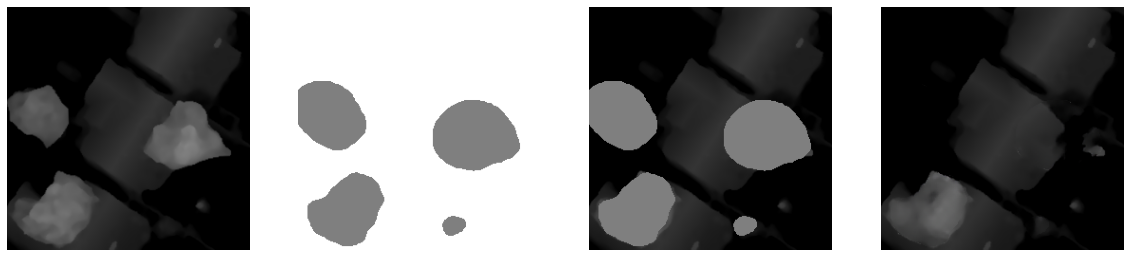

In [124]:
best, samples = inf.on_tiff("/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/54_dem.tiff",
                            "/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/54_tree_mask.npz")

In [246]:
import json

with open("/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/54.json") as fp:
    
    attr_geom_js = json.load(fp)['Target.BuildingGeometry']

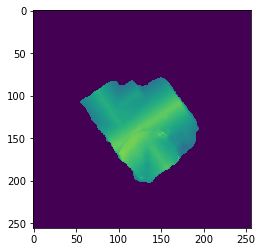

In [250]:
isolated_roof, mask_roof, new_attr_geom = get_masked_reconstructed_dem(attr_geom_js, new_dem, threshold_height=2.0)

_ = plt.imshow(isolated_roof.raster, vmin=0)

In [121]:
new_dem.save("output.tif")

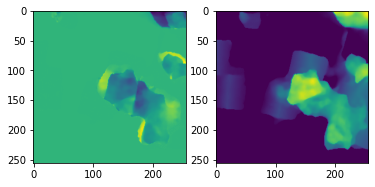

In [98]:
fig, sub = plt.subplots(1, 2)
sub[0].imshow(scale[np.array(Image.fromarray(reconstructed).convert("L"))] - dem.T)
sub[1].imshow(dem.T)

In [100]:
v = (scale[np.array(Image.fromarray(reconstructed).convert("L"))] - dem.T)

In [107]:
from collections import Counter

Counter(v.flatten().tolist()).most_common(1)

[(0.0, 36174)]

In [126]:


path='/home/giacomov/cape/nearmap_3d_alpha/state_auto/test_gan/20_dem.tiff'
out_path='output.tif'
crp=256

crop_geotiff(path, crp, out_path)

(1, 256, 256)
